# qSystem 2
This system includes the following components:
* 1 output channels connected to PMOD0-3 and triggers for Readout Block.
* 7 output channels connected to DACs.
* 2 input channels connected to ADCs.
* 1 instance of tProcessor 64-bit instructions, 32-bit registers.

Sampling frequency of ADC blocks is given by the variable `soc.fs_adc`. Sampling frequency of DACs is stored in variable `soc.fs_adc`. Fast-speed buffers were removed to save memory space. Raw data can be captured after x8 down-sampling.

Output channels driving DACs use the updated Signal Generator V4, which has the possibility to upload I/Q envelopes, and uses 32-bit resolution for both frequency and phase. The format of the control word was updated accordingly to accomodate the bits. See example asm files for a detailed description of the fields. The maximum length of the I/Q envelopes is given by the variable `soc.gens[i].MAX_LENGTH`.

Readout block is actually built around two IPs: readout and average + buffer. Readout block inlcudes a digital down-convertion, FIR filtering and decimation by 8. DDS frequency is configured using a register of the readout block and it is not intended to support real-time frequency hopping as in the Signal Generator side. After frequency shifting, filtering and decimation, the data stream is sent to the Average + Buffer block, which internally can store raw samples or perform the sum of the specified number of samples. The process is started with the external trigger signal, connected to output Channel 0 of tProcessor. The user can opt to route the input, the DDS wave or the frequency shifted signal to the FIR and decimation by 8 stage. This is done using a output selection register of the readout block. Regarding the buffering capabilities, the average section of the block has a buffer of `soc.avg_bufs[i].AVG_MAX_LENGTH`.

### tProcessor channel assignment
tProcessor will be used to control the real-time operation of the experiment. Output channels (AXIS MASTER) of the tProcessor are assigned as follows:
* Channel 0 : connected to PMOD0 0-3, and triggers for readout. Bits 0-3 are connected to PMOD0, bit 14 is connected to the trigger of the average/buffer block coming from the readout of ADC 224 CH0. Bit 15 is connected to the trigger of the average/buffer block coming from the readout of ADC 224 CH1.
* Channel 1 : connected to Signal Generator V4, which drives DAC 228 CH0.
* Channel 2 : connected to Signal Generator V4, which drives DAC 228 CH1.
* Channel 3 : connected to Signal Generator V4, which drives DAC 228 CH2.
* Channel 4 : connected to Signal Generator V4, which drives DAC 229 CH0.
* Channel 5 : connected to Signal Generator V4, which drives DAC 229 CH1.
* Channel 6 : connected to Signal Generator V4, which drives DAC 229 CH2.
* Channel 7 : connected to Signal Generator V4, which drives DAC 229 CH3.

The updated version of the tProcessor has 4 input (AXIS SLAVE) channels, which can be used for feedback. These are 64-bit, and the updated `read` instruction can specify channel number and upper/lower 32-bits to be read and written into an internal register. See example below on how to use this new capability.
* Channel 0 : connected to reaadout 0, which is driven by ADC 224 CH0
* Channel 1 : connected to reaadout 1, which is driven by ADC 224 CH1

Signal Generators are organized on the array `soc.gens`, which is composed of 7 instances. Array index 0 is connected to tProcessor Channel 1, array index 1 is connected to tProcessor Channel 2, and so on. As way of example, let's assume the user needs to create a pulse on DAC 229 CH1 and DAC 229 CH3. These are connected to Channels 5, and 7 or the tProcessor, respectively. However, let's also assume that a gaussian envelope needs to be uploaded into the corresponding signal generator. `soc.gens[3]` drives DAC 229 CH1, and `soc.gens[6]` drives DAC 229 CH3.

Similarly, average and buffer inputs blocks are organized on `soc.avg_bufs` array, which has two instances of the Average + Buffer block. The user can access them using index 0 and 1.

### Driver and parser
To simplify the reading of the notebook and examples, the software is divided in three files: this main notebook `qsystem_2.ipynb`, which is intended to include example code, driver file `qsystem_2.py` with specific drivers and system instantiation, and `parser.py` which separates the assembler parser.

In [13]:
from qsystem_2 import *

In [21]:
# Load bitstream with custom overlay
soc = PfbSoc('qsystem_2.bit',ignore_version=True, force_init_clks=False)

In [15]:
# Start tProc.
soc.tproc.stop()
soc.tproc.start()

In [16]:
###########################
### Sine Wave Generator ###
###########################
# This asm file will create sine waves on channels 4,5,6,7, connected to DAC 229 CH0/1/2/3.
f0 = 330
tmp = freq2reg(fs=soc.fs_dac,f=f0, B=32)
soc.tproc.single_write(addr=123, data=tmp)

# Load program.
soc.tproc.load_program("sine.asm")


131
di_raw_sum = 11076, di_feed = 11076, di = 11076
dq_raw_sum = -442, dq_feed = -442, dq = -442


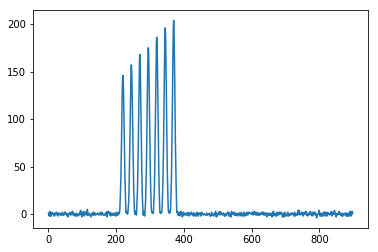

In [22]:
#########################
### Gaussian Envelope ###
#########################
# This asm file uses:
# |--------------------------------------------------|
# | tProc Out CH | DAC Tile | DAC Number | Generator |
# |--------------|----------|------------|-----------|
# |            6 |      229 |          2 |         5 |
# |            7 |      229 |          3 |         6 |
# |--------------------------------------------------|
#
# For readout:
# ADC 224 CH0, connected to readout 0, bit 14 of channel 0 tProc.
#
# tProcessor memory map:
# @17 : DAC frequency.
# @18 : DAC pulse length.
# @19 : sync value.
# @33 : Number or repetitions.
# @55 : Real part of average (feedback).
# @56 : Imaginary part of average (feedback).
xg_i = gauss(mu=150, si=80, length=300, maxv=30000)
xg_q = np.zeros(len(xg_i))

# Upload waveform.
gen = soc.gens[5].load(addr=0,xin_i=xg_i, xin_q=xg_q)
gen = soc.gens[6].load(addr=0,xin_i=xg_i, xin_q=xg_q)

# Compute DDS frequency.
fout = 233
tmp = freq2reg(fs=soc.fs_dac,f=fout,B=32)
soc.tproc.single_write(addr=17,data=tmp)

# Compute pulse length.
Np = int(len(xg_i)/soc.gens[0].NDDS)
soc.tproc.single_write(addr=18,data=Np)

# tProc sync value to separate pulses.
Nsync = int(Np*1.4)
soc.tproc.single_write(addr=19,data=Nsync)

# Number of repetitions.
N = 7
soc.tproc.single_write(addr=33, data=N-1)

# Load program.
soc.tproc.load_program("gaussian_env.asm")

# Number of total samples.
NTdac = N*len(xg_i)
NTadc = NTdac*soc.fs_adc/soc.fs_dac
NTadc_dec = int(NTadc/8)
print(NTadc_dec)

# Configure readout.
soc.readouts[0].set_out("product")
soc.readouts[0].set_freq(fout)
soc.avg_bufs[0].config(address=0, length=900)
soc.avg_bufs[0].enable()

time.sleep(1)

# Start tProc.
soc.tproc.stop()
soc.tproc.start()

time.sleep(1)

# Raw data.
[di_raw,dq_raw] = soc.get_decimated(ch=0, length=900)
plt.plot(di_raw)

# Accumulated data.
[di,dq] = soc.get_accumulated(ch=0, length=16)

# Feedback of accumulated data.
di_feed = soc.tproc.single_read(addr=55)
dq_feed = soc.tproc.single_read(addr=56)
if di_feed>2**31:
    di_feed = di_feed - 2**32
if dq_feed>2**31:
    dq_feed = dq_feed - 2**32
    
# Accumulate raw data in Python for comparison.
di_raw_sum = np.sum(di_raw)
dq_raw_sum = np.sum(dq_raw)

# Comparison.
print("di_raw_sum = %d, di_feed = %d, di = %d" %(di_raw_sum, di_feed, di[0]))
print("dq_raw_sum = %d, dq_feed = %d, dq = %d" %(dq_raw_sum, dq_feed, dq[0]))

In [ ]:
320*16